## Setup

In [1]:
# Impor matplotlib dan buat fungsi pembantu untuk memplot grafik
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [2]:
# Setup input pipeline
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
# Awalnya ini mengembalikan dataset (teks, pasangan label)
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [4]:
# Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I understand this film to be a debut feature and as such, it is very impressive. It has the feel and pacing of a "true indie", yet director Todd Yellin clearly possesses the photographic and editorial vision, command and judgment of a mature and seasoned professional. The shots are well framed and thought out and serve to move the story forward. He, and screenwriter Ivan Solomon deliver a story that has much more depth and lyricism than typical "paint by numbers" type scripts. It\'s a story that needs Judd Hirsch caliber character talent to have a shot at working. Judd is fantastic as usual; as are Scott Cohen and the beautiful Susan Floyd. The real surprise though is Elliot Korte who plays Adam Groden. Yellin was able to coax nuance out of the young actor in a role that could have been easily devalued by stereotype or overreach. Anyway, I found the film refreshing and entertaining.'
 b"<br /><br />I saw once No Man's Land (1987) - IMDB link http://us.imdb.com/Title?0093638 

## Buat Teks Encoder

In [5]:
# Buat Teks Encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [6]:
# Metode .adapt mengatur kosakata lapisan. 20 token pertama
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:
# Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 373,  11, ...,   0,   0,   0],
       [ 13,  13,  10, ...,   0,   0,   0],
       [ 45, 320,   4, ...,   0,   0,   0]])

In [8]:
# Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I understand this film to be a debut feature and as such, it is very impressive. It has the feel and pacing of a "true indie", yet director Todd Yellin clearly possesses the photographic and editorial vision, command and judgment of a mature and seasoned professional. The shots are well framed and thought out and serve to move the story forward. He, and screenwriter Ivan Solomon deliver a story that has much more depth and lyricism than typical "paint by numbers" type scripts. It\'s a story that needs Judd Hirsch caliber character talent to have a shot at working. Judd is fantastic as usual; as are Scott Cohen and the beautiful Susan Floyd. The real surprise though is Elliot Korte who plays Adam Groden. Yellin was able to coax nuance out of the young actor in a role that could have been easily devalued by stereotype or overreach. Anyway, I found the film refreshing and entertaining.'
Round-trip:  i understand this film to be a [UNK] feature and as such it is very [UNK] it 

## Buat Model

In [9]:
# Buat Model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [10]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [11]:
# evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01389584]


In [12]:
# evaluasi lagi dalam batch dengan kalimat yang lebih panjang
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 83ms/step
[0.01389584]


In [13]:
# compile model Keras untuk mengonfigurasi proses pelatihan
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

Epoch 1/10
391/391 [==============================] - 49s 99ms/step - loss: 0.6360 - accuracy: 0.5709 - val_loss: 0.5075 - val_accuracy: 0.7323
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4451 - accuracy: 0.7857 - val_loss: 0.4030 - val_accuracy: 0.8250
Epoch 3/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3667 - accuracy: 0.8385 - val_loss: 0.4034 - val_accuracy: 0.8438
Epoch 4/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3347 - accuracy: 0.8566 - val_loss: 0.3395 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3174 - accuracy: 0.8640 - val_loss: 0.3314 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3095 - accuracy: 0.8696 - val_loss: 0.3258 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3055 - accuracy: 0.8710 - val_loss: 0.3221 - val_accuracy:

(0.0, 0.6529179990291596)

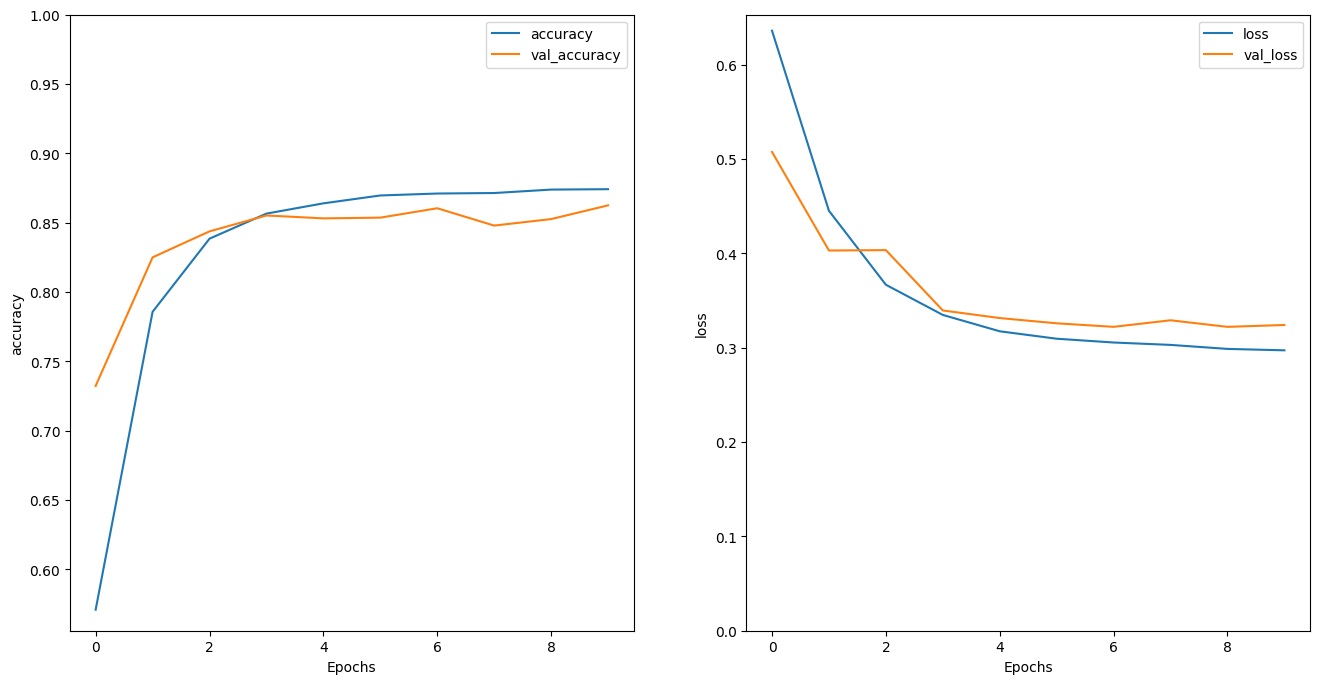

In [14]:
# Train Model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [15]:
# Jalankan prediksi pada kalimat baru
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


## Stack two or more LSTM layers

In [16]:
# Stack two or more LSTM layers
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 147ms/step - loss: 0.6234 - accuracy: 0.5922 - val_loss: 0.4382 - val_accuracy: 0.8297
Epoch 2/10
391/391 [==============================] - 43s 111ms/step - loss: 0.3851 - accuracy: 0.8328 - val_loss: 0.3528 - val_accuracy: 0.8406
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3351 - accuracy: 0.8586 - val_loss: 0.3274 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3200 - accuracy: 0.8631 - val_loss: 0.3242 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 43s 110ms/step - loss: 0.3101 - accuracy: 0.8680 - val_loss: 0.3241 - val_accuracy: 0.8495
Epoch 6/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3069 - accuracy: 0.8686 - val_loss: 0.3182 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 44s 111ms/step - loss: 0.2996 - accuracy: 0.8722 - val_loss: 0.3326 - val_ac

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 44ms/step - loss: 0.3184 - accuracy: 0.8626
Test Loss: 0.3183877468109131
Test Accuracy: 0.8626400232315063


In [20]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.867612]]


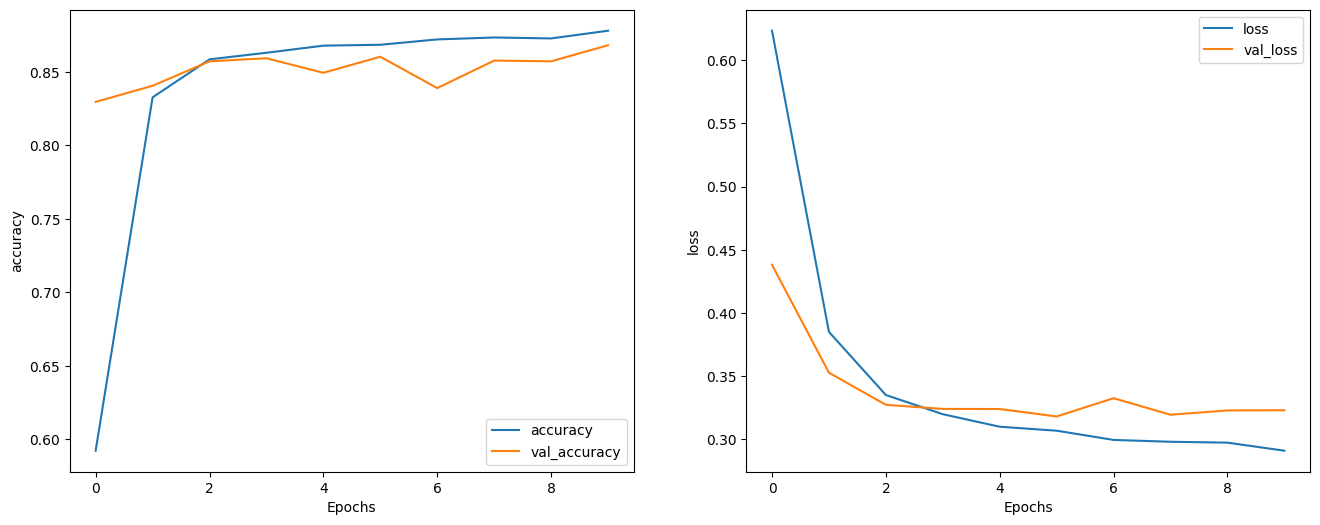

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')